In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intro

This work is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given state
ment (fact) conveys a trustworthy information or not.

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [ ]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding.

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix.

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set.

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs.

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

# Tips and Extras

## Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

Don't forget to try neural baselines first!

## Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# OUR ASSIGMENT

In [ ]:
# Some imports
import csv
import pandas as pd

from functools import reduce
import re

import tensorflow as tf
from keras.layers import Input, Dense, LSTM,Flatten, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, GRU, Dropout, Masking,Concatenate, Lambda, Add, Average, Dot
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD

import copy

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report, f1_score



#### DATASET PRE-PROCESSING

In [ ]:
# Load dataset and save it into a pd dataframe

def encode_dataset(dataset_path):
  dataset_name = dataset_path.split("/")[-1].split("_")[0]
  print(dataset_name)
  with open(dataset_path, newline='', encoding='utf-8') as f:
    dataframe_rows = []

    reader = csv.reader(f)

    for row in reader:
      # create single dataframe row
      dataframe_row = {
        "claim": row[1],
        "evidence": row[2],
        "ID": row[3],
        "label": row[4]
        }
      dataframe_rows.append(dataframe_row)

    # delete first row: it contains the header
    dataframe_rows = dataframe_rows[1:]

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["claim",
              "evidence",
              "ID",
              "label"]]
    dataframe_path = os.path.join("/content/dataset/", dataset_name + ".pkl")
    df.to_pickle(dataframe_path)

    return df


# Encoding
print("Encoding dataset...")
df_train = encode_dataset("/content/dataset/train_pairs.csv")
df_val = encode_dataset("/content/dataset/val_pairs.csv")
df_test = encode_dataset("/content/dataset/test_pairs.csv")


print("Encoding completed!")

Encoding dataset...
train
val
test
Encoding completed!


In [ ]:
# Print some sentences for debugging

print(df_train.head())
print()
print(df_val.head())
print()
print(df_test.head())

print()
print("first 15 claims of test")
for el in df_test['claim'][0:15]:
  print(el)

print()

print()
print("first 15 evidences of test")
for el in df_test['evidence'][3276:3280]:
  print(el)


                                               claim  ...     label
0     Chris Hemsworth appeared in A Perfect Getaway.  ...  SUPPORTS
1                            Roald Dahl is a writer.  ...  SUPPORTS
2                          Roald Dahl is a governor.  ...   REFUTES
3        Ireland has relatively low-lying mountains.  ...  SUPPORTS
4  Ireland does not have relatively low-lying mou...  ...   REFUTES

[5 rows x 4 columns]

                                               claim  ...     label
0  The Indian Army comprises part of the country'...  ...  SUPPORTS
1                         Recovery features Rihanna.  ...  SUPPORTS
2                            Rihanna is on Recovery.  ...  SUPPORTS
3                           Philomena was nominated.  ...  SUPPORTS
4                               Vietnam is a mascot.  ...   REFUTES

[5 rows x 4 columns]

                                               claim  ...     label
0    Anxiety has been linked with physical symptoms.  ...  SUPPORTS
1 

In [ ]:
# Print some evidences for checking

for x in df_train[:3].evidence:
  print(x)

2	Hemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LRB- 2012 -RRB- , the dark-fantasy action film Snow White and the Huntsman -LRB- 2012 -RRB- , the war film Red Dawn -LRB- 2012 -RRB- , and the biographical sports drama film Rush -LRB- 2013 -RRB- .	Star Trek	Star Trek (film)	A Perfect Getaway	A Perfect Getaway	The Cabin in the Woods	The Cabin in the Woods	Snow White and the Huntsman	Snow White and the Huntsman	Red Dawn	Red Dawn (2012 film)	Rush	Rush (2013 film)
0	Roald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
0	Roald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novel

In [ ]:
# Clean data

# Function to remove the first part of the evidence.
# Indeed each evidence begins with a number followe by a tab space.
# That number specifies the sentence number (ID) in the pointed document to consider.
# It is not an important information for this task.
def remove_first_number(text):
  text = re.sub("^[0-9]+", '', text)
  return text


#Function useful to remove punctuation
def remove_punctuation(text):
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  return text


# Function useful to remove the final part of each evidence.
# Indeed each evidence is composed by a phrase containing a ".". After the perior there are some information
# that are disambiguation information reported by Wikipedia. These words are simply noise.
def remove_final_part(text):
  text = re.sub(r"(.*)\.(.*)",r"\1",text)
  return text #.split(".")[0]


# Function to remove any left or right spacing (including carriage return), tab etc.
# For instance:
# Input: '  I'm a     student\n'
# Output: 'I'm a student'
def strip_text(text):
    return ' '.join(text.split()).strip()


#The -LRB- and -RRB- are currently used instead of "(" and ")" in Form
# The LRB (Left Round Bracket) and RRB (Right Round Brackets) and in past (-LCB-, -RCB-, -LSB-, -RSB-)
def replace_brackets(text):
  text = re.sub(r"LRB", "(", text)
  text = re.sub(r"RRB", ")", text)
  text = re.sub(r"LCB", "{", text)
  text = re.sub(r"RCB", "}", text)
  text = re.sub(r"LSB", "[", text)
  text = re.sub(r"RSB", "]", text)
  return text


# Additional function to remove English contractions
# Given that the computer does not know that contractions are abbreviations for a sequence of words,
# it considers for instance "can't", "cannot" and "can not" to be completely different things.
# So it can't understand that these terms have the exact same meaning if we don't remove them.
# Moreover handling contractions makes the vocabulary smaller and so the computation faster.
def remove_contraction(text):
  text = re.sub(r"cannot", "can not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"won't", " will not", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"\'m ", " am ", text)
  text = re.sub(r"\'s ", " ", text)
  text = re.sub(r"\'ve ", " have ", text)
  text = re.sub(r"\'re ", " are ", text)
  text = re.sub(r"\'d ", " would ", text)
  text = re.sub(r"\'ll ", " will ", text)
  text = re.sub(r" u ", " you ", text)
  return text


# In square brackets it is specified how to pronounce a certain word (e.g. a proper noun).
# If we don't remove the pronunciation, it will introduce noise.
# For instance "[ langpronˈroʊ.əld ]" becomes "langpronroʊəld" (because we remove every sign of punctuation too) that has no meaning.
# Moreover how to pronounce a word is not so important for this task. For this reason we remove what is in square brackets.
def remove_pronunciation(text):
  text = re.sub(r"\[.*\]", "", text)
  return text

def lower(text):
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()


In [ ]:
PREPROCESSING_PIPELINE = [
                          remove_contraction, #to remove some English contractions
                          replace_brackets,
                          remove_pronunciation,
                          remove_first_number,
                          remove_final_part,
                          remove_punctuation,
                          strip_text,
                          lower
                          ]


# Anchor method
def text_prepare(text, filter_methods=None):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)


In [ ]:
print('Pre-processing text...')

print()
print('...EVIDENCES...')
print()
print('[Debug] Before:\n{}'.format(df_train.evidence[:3]))
print()


# Replace each sentence with its pre-processed version
df_train['evidence'] = df_train['evidence'].apply(lambda txt: text_prepare(txt))
df_val['evidence'] = df_val['evidence'].apply(lambda txt: text_prepare(txt))
print('[Debug] After:\n{}'.format(df_train.evidence[:3]))
print()


print('...CLAIMS...')
print()
print('[Debug] Before:\n{}'.format(df_train.claim[:3]))
print()


# Replace each sentence with its pre-processed version
df_train['claim'] = df_train['claim'].apply(lambda txt: text_prepare(txt))
df_val['claim'] = df_val['claim'].apply(lambda txt: text_prepare(txt))

print('[Debug] After:\n{}'.format(df_train.claim[:3]))
print()


print("Pre-processing completed!")

Pre-processing text...

...EVIDENCES...

[Debug] Before:
0    2\tHemsworth has also appeared in the science ...
1    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
Name: evidence, dtype: object

[Debug] After:
0    hemsworth has also appeared in the science fic...
1    roald dahl 13 september 1916 23 november 1990 ...
2    roald dahl 13 september 1916 23 november 1990 ...
Name: evidence, dtype: object

...CLAIMS...

[Debug] Before:
0    Chris Hemsworth appeared in A Perfect Getaway.
1                           Roald Dahl is a writer.
2                         Roald Dahl is a governor.
Name: claim, dtype: object

[Debug] After:
0    chris hemsworth appeared in a perfect getaway
1                           roald dahl is a writer
2                         roald dahl is a governor
Name: claim, dtype: object

Pre-processing completed!


In [ ]:
for x in df_train[:3].evidence:
  print(x)

hemsworth has also appeared in the science fiction action film star trek 2009 the thriller adventure a perfect getaway 2009 the horror comedy the cabin in the woods 2012 the darkfantasy action film snow white and the huntsman 2012 the war film red dawn 2012 and the biographical sports drama film rush 2013
roald dahl 13 september 1916 23 november 1990 was a british novelist short story writer poet screenwriter and fighter pilot
roald dahl 13 september 1916 23 november 1990 was a british novelist short story writer poet screenwriter and fighter pilot


In [ ]:
for x in df_val[:3].evidence:
  print(x)

it is an allvolunteer force and comprises more than 80 of the country active defence personnel
eminem also collaborated with artists such as pink lil wayne slaughterhouse and rihanna for the album
eminem also collaborated with artists such as pink lil wayne slaughterhouse and rihanna for the album


#### DATASET CONVERSION

In [ ]:
# Auxiliary functions

# Function that counts the max length of the sentences
def max_len(df):
  len_max = 0
  for indice, el in enumerate(df.sentence):
    if len_max < len(el):
      len_max = len(el)
      counter = indice
  return len_max


# Function useful to build vocabulary for words
def build_vocabulary(df):
  word_listing = ['<PAD>','<UNK>']
  for x in ' '.join(df.claim.tolist()).split():
    if x not in word_listing:
      word_listing.append(x)

  for x in ' '.join(df.evidence.tolist()).split():
    if x not in word_listing:
      word_listing.append(x)

  word_to_ind = {word : idx for idx,word in enumerate(word_listing)}
  ind_to_word = dict(zip(word_to_ind.values(), word_to_ind.keys()))
  return ind_to_word, word_to_ind, word_listing


def add_build_vocabulary(df, w2i):
  w2i_tot = copy.deepcopy(w2i)

  for x in ' '.join(df.claim.tolist()).split():
    if x not in w2i_tot:
      w2i_tot[x] = len(w2i_tot)

  for x in ' '.join(df.evidence.tolist()).split():
    if x not in w2i_tot:
      w2i_tot[x] = len(w2i_tot)

  i2w_tot = dict(zip(w2i_tot.values(), w2i_tot.keys()))
  return i2w_tot, w2i_tot


def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    OOV_terms = [x for x in word_listing if x not in embedding_model and x != '<PAD>' and x!= '<UNK>']
    return OOV_terms



In [ ]:
# Build vocabularies for train and val

idx_to_word_train, word_to_idx_train, word_listing_train = build_vocabulary(df_train)
idx_to_word_val, word_to_idx_val= add_build_vocabulary(df_val, word_to_idx_train)


In [ ]:
import numpy as np
print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word_train)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx_train)))

print('[Debug] Some words: {}'.format([(idx_to_word_train[idx], idx) for idx in np.arange(10) + 1]))
print(word_listing_train)
print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word_val)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx_val)))

print('[Debug] Some words: {}'.format([(idx_to_word_val[idx], idx) for idx in np.arange(10) + 1]))


[Debug] Index -> Word vocabulary size: 33489
[Debug] Word -> Index vocabulary size: 33489
[Debug] Some words: [('<UNK>', 1), ('chris', 2), ('hemsworth', 3), ('appeared', 4), ('in', 5), ('a', 6), ('perfect', 7), ('getaway', 8), ('roald', 9), ('dahl', 10)]
['<PAD>', '<UNK>', 'chris', 'hemsworth', 'appeared', 'in', 'a', 'perfect', 'getaway', 'roald', 'dahl', 'is', 'writer', 'governor', 'ireland', 'has', 'relatively', 'lowlying', 'mountains', 'does', 'not', 'have', 'there', 'been', 'many', 'notable', 'performances', 'by', 'david', 'thewlis', 'edward', 'i', 'of', 'england', 'responded', 'to', 'second', 'rebellion', '1282', 'h', 'holmes', 'owned', 'building', 'west', 'chicago', 'was', 'the', 'owner', 'located', 'beastie', 'boys', 'released', 'paul', 'boutique', 'debbie', 'reynolds', 'an', 'actress', 'performer', 'greece', 'country', 'european', 'liverpool', 'fc', 'valued', 'at', '155', 'billion', 'australia', 'member', '8', 'intergovernmental', 'organizations', 'ringo', 'starr', 'hospitalize

In [ ]:
# Load pre-trained embedding model
import gensim
import gensim.downloader as gloader
import numpy as np


embedding_model_type = "glove"
embedding_dimension = 300

embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# Convert sentences into numbers (only for train set)
def convert_sentence_idx(df,word_to_idx):
  sentence = []
  for el in df.tolist():
    el = el.split(' ')
    y = []
    for w in el:
      y.append( word_to_idx[w])
    sentence.append(y)
  return sentence

# Convert sentences into numbers (for val e test set)
def convert_sentence_idx_val(df,word_to_idx,oov_terms):
  sentence = []
  for el in df.tolist():
    el = el.split(' ')
    y = []
    for w in el:
      if w in oov_terms:
        y.append(word_to_idx['<UNK>'])
      else:
        y.append( word_to_idx[w])
    sentence.append(y)
  return sentence


In [ ]:
def build_embedding_matrix_rand(embedding_model, embedding_dimension, word_to_idx, oov_terms):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param oov_terms: list of OOV terms (list)
    :param co_occorruence_count_matrix: the co-occurrence count matrix of the given dataset (window size 1)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    ### YOUR CODE HERE ###

    embedding_matrix = np.zeros((len(word_to_idx),embedding_dimension))
    for index,w in enumerate(word_to_idx):
      if w == '<PAD>':
        continue
      elif w in oov_terms or w == '<UNK>':
        embedding_matrix[index] = np.random.rand(embedding_dimension)
      else:
        embedding_matrix[index] = embedding_model[w]
    return embedding_matrix


In [ ]:
# Check OOV and build embedding vocabularies for train and validation
# Handle OVV terms
import scipy
oov_terms_train = check_OOV_terms(embedding_model, word_listing_train)
print("TRAIN: Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_train), float(len(oov_terms_train)) / len(word_listing_train)))
print()


V1 = build_embedding_matrix_rand(embedding_model,embedding_dimension,word_to_idx_train,oov_terms_train)


oov_terms_val = check_OOV_terms(word_listing_train, list(word_to_idx_val.keys()))

print()

# Convert train sequences into numbers
claim_to_idx = convert_sentence_idx(df_train.claim,word_to_idx_train)
evidence_to_idx = convert_sentence_idx(df_train.evidence,word_to_idx_train)
sentence_to_idx = claim_to_idx + evidence_to_idx
print(len(sentence_to_idx))

# Convert validation sequences into numbers
claim_to_idx_val = convert_sentence_idx_val(df_val.claim,word_to_idx_val, oov_terms_val)
evidence_to_idx_val = convert_sentence_idx_val(df_val.evidence,word_to_idx_val, oov_terms_val)
sentence_to_idx_val = claim_to_idx_val + evidence_to_idx_val
print(len(sentence_to_idx_val))


TRAIN: Total OOV terms: 4687 (0.14%)


243480
14330


In [ ]:
# Function that counts the max length of the sentences
def max_len(sentence_to_idx):
  len_max = 0
  for indice, el in enumerate(sentence_to_idx):
    if len_max < len(el):
      len_max = len(el)
  return len_max

max = max_len(sentence_to_idx)
print(max)

202


In [ ]:
#Pad sequence for train

from keras.preprocessing.sequence import pad_sequences
max = max_len(sentence_to_idx)
print(max)
claim_train = pad_sequences(claim_to_idx, padding='post', maxlen=max)
evidence_train = pad_sequences(evidence_to_idx, padding='post', maxlen=max)
X_train = (claim_train, evidence_train)

202


In [ ]:
#Pad sequence for val
from keras.preprocessing.sequence import pad_sequences
claim_val = pad_sequences(claim_to_idx_val, padding='post', maxlen=max)
evidence_val = pad_sequences(evidence_to_idx_val, padding='post', maxlen=max)
X_val = (claim_val, evidence_val)

In [ ]:
def prepare_labels(df):
  labels = []
  for element in df:
    if element not in labels:
      labels.append(element)
  labels_to_idx = { label : index for index, label in enumerate(labels)}
  idx_to_labels = dict(zip(labels_to_idx.values(), labels_to_idx.keys()))
  return labels_to_idx, idx_to_labels


labels_to_idx, idx_to_labels = prepare_labels(df_train.label)
print(labels_to_idx)
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_train.label)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)


integer_encoded_val = label_encoder.fit_transform(df_val.label)
print(integer_encoded_val)

# binary encode
onehot_encoder_val = OneHotEncoder(sparse=False)
integer_encoded_val = integer_encoded_val.reshape(len(integer_encoded_val), 1)
onehot_encoded_val = onehot_encoder_val.fit_transform(integer_encoded_val)
print(onehot_encoded_val)

{'SUPPORTS': 0, 'REFUTES': 1}
[1 1 0 ... 0 1 0]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[1 1 1 ... 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#### MODELS DEFINITION

In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: concatenation

def create_model_1():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features =  Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)  #Encode token sequences via a RNN and take the last state as the sentence embedding
                                                                           #Each LSTM cell will output one hidden state h for each input. So it is already ok

  # Merge all available features into a single large vector via concatenation
  concatenation = Concatenate(name = 'concatenation')([claim_features, evidence_features])

  #MLP
  output = Dense(16, name = 'dense_1')(concatenation)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)



  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: Sum
def create_model_2():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features = Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)

  # Merge all available features into a single vector by summing them
  merging = Add(name = 'sum')([claim_features, evidence_features])

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)


  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: MEAN
def create_model_3():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features = Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)

  # Merge all available features into a single vector by doing the mean
  merging = Average(name = 'mean')([claim_features, evidence_features])


  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)


  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
from keras import backend as K

def mean(input):
    return K.mean(input, axis=1, keepdims=False)

In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and average all the output states.
#MERGING INPUTS: concatenation

def create_model_4():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features = Bidirectional(LSTM(64, name = 'lstm_claim', return_sequences = True))(encoded_claim)
  # Average all the output states
  claim_features = Lambda(mean, input_shape=(202,300))(claim_features)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence', return_sequences = True))(encoded_evidence)
  # Average all the output states
  evidence_features = Lambda(mean, input_shape=(202,300))(evidence_features)

  # Merge all available features into a single large vector via concatenation
  merging = Concatenate(name = 'concatenation')([claim_features, evidence_features])

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and average all the output states.
#MERGING INPUTS: sum

def create_model_5():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features =Bidirectional(LSTM(64, name = 'lstm_claim', return_sequences = True))(encoded_claim)
  # Average all the output states
  claim_features = Lambda(mean, input_shape=(202,300))(claim_features)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence', return_sequences = True))(encoded_evidence)
  # Average all the output states
  evidence_features = Lambda(mean, input_shape=(None,None))(evidence_features)

  # Merge all available features into a single large vector via concatenation
  merging = Add(name = 'sum')([claim_features, evidence_features])

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)


  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model


In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and average all the output states.
#MERGING INPUTS: average

def create_model_6():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features = Bidirectional(LSTM(64, name = 'lstm_claim', return_sequences = True))(encoded_claim)
  # Average all the output states
  claim_features = Lambda(mean, input_shape=(202,300))(claim_features)


  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence', return_sequences = True))(encoded_evidence)
  # Average all the output states
  evidence_features = Lambda(mean, input_shape=(None,None))(evidence_features)

  # Merge all available features by doing the mean
  merging = Average(name = 'mean')([claim_features, evidence_features])

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)



  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a simple MLP layer.
#MERGING INPUTS: concatenation

def create_model_7():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_flatten = Flatten(name = 'flatten_claim')(encoded_claim)
  claim_features = Dense(128, name = 'mlp_claim')(claim_flatten)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_flatten = Flatten(name = 'flatten_evidence')(encoded_evidence)
  evidence_features = Dense(128, name = 'mlp_evidence')(evidence_flatten)

  # Merge all available features into a single large vector via concatenation
  merging = Concatenate(name = 'concatenation')([claim_features, evidence_features])

  #MLP
  output = Dense(4, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  #output = Dense(4, name = 'dense_2')(output)
  #output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=SGD(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a simple MLP layer.
#MERGING INPUTS: sum

def create_model_8():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_flatten = Flatten(name = 'flatten_claim')(encoded_claim)
  claim_features = Dense(128, name = 'mlp_claim')(claim_flatten)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_flatten = Flatten(name = 'flatten_evidence')(encoded_evidence)
  evidence_features = Dense(128, name = 'mlp_evidence')(evidence_flatten)


  # Merge all available features by summing them
  merging = Add(name = 'sum')([claim_features, evidence_features])

  #MLP
  output = Dense(4, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  #output = Dense(4, name = 'dense_2')(output)
  #output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)


  model.compile(loss='binary_crossentropy',
                optimizer=SGD(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a simple MLP layer.
#MERGING INPUTS: mean

def create_model_9():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_flatten = Flatten(name = 'flatten_claim')(encoded_claim)
  claim_features = Dense(128, name = 'mlp_claim')(claim_flatten)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_flatten = Flatten(name = 'flatten_evidence')(encoded_evidence)
  evidence_features = Dense(128, name = 'mlp_evidence')(evidence_flatten)


  # Merge all available features by doing the mean
  merging = Average(name = 'mean')([claim_features, evidence_features])

  #MLP
  output = Dense(4, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  #output = Dense(4, name = 'dense_2')(output)
  #output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)


  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=SGD(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
def mean_bagofvectors(input):
    return K.mean(input, axis=-1, keepdims=False)

In [ ]:
#SENTENCE EMBEDDING: Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
#MERGING INPUTS: concatenation

def create_model_10():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  # Average all the output states
  claim_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_claim)


  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  # Average all the output states
  evidence_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_evidence)

  # Merge all available features into a single large vector via concatenation
  concatenation = Concatenate(name = 'concatenation')([claim_features, evidence_features])

  #MLP
  output = Dense(128, name = 'dense_1')(concatenation)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(32, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)


  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
#MERGING INPUTS: sum

def create_model_11():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  # Average all the output states
  claim_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_claim)

  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  # Average all the output states
  evidence_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_evidence)

  # Merge all available features by doing the sum
  merging = Add(name = 'sum')([claim_features, evidence_features])

  #MLP
  output = Dense(128, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(32, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)

  model = Model(inputs = [claim_input,evidence_input], outputs = output)


  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
#MERGING INPUTS: mean

def create_model_12():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  # Average all the output states
  claim_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_claim)


  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  # Average all the output states
  evidence_features = Lambda(mean_bagofvectors, input_shape=(202,300))(encoded_evidence)

  # Merge all available features by doing the mean
  merging = Average(name = 'mean')([claim_features, evidence_features])

  #MLP
  output = Dense(128, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(32, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)


  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: concatenation
#This net considers the cosine similarity too.

def create_model_13():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features =  Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)

  cosine = Dot(axes=1, normalize=True)([claim_features, evidence_features])

  # Merge all available features into a single large vector via concatenation
  merging = Concatenate(name = 'concatenation')([claim_features, evidence_features, cosine])

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)



  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: sum
#This net considers the cosine similarity too.

def create_model_14():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features =  Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)

  cosine = Dot(axes=1, normalize=True)([claim_features, evidence_features])

  # Merge all available features by doing the sum
  merging = Add(name = 'sum')([claim_features, evidence_features, cosine])
  #flatten_concat = Flatten

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)



  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



In [ ]:
#SENTENCE EMBEDDING: Encode token sequences via a RNN and take the last state as the sentence embedding.
#MERGING INPUTS: concatenation
#This net considers the cosine similarity too.

def create_model_15():

  shared_embedding = Embedding(input_dim=len(word_to_idx_train), output_dim=embedding_dimension, weights = [V1], trainable = True, mask_zero = True, name = 'shared_embedding')

  #sentence encoding for claim
  claim_input = Input(shape = (X_train[0].shape[1],), dtype = "float32", name = 'claim_input')
  encoded_claim = shared_embedding(claim_input)
  claim_features =  Bidirectional(LSTM(64, name = 'lstm_claim'))(encoded_claim)

  #sentence encoding for evidence
  evidence_input = Input(shape = (X_train[1].shape[1],), dtype = "float32", name = 'evidence_input')
  encoded_evidence = shared_embedding(evidence_input)
  evidence_features = Bidirectional(LSTM(64, name = 'lstm_evidence'))(encoded_evidence)

  cosine = Dot(axes=1, normalize=True)([claim_features, evidence_features])

  # Merge all available features into a single large vector via concatenation
  merging = Average(name = 'mean')([claim_features, evidence_features, cosine])
  #flatten_concat = Flatten

  #MLP
  output = Dense(16, name = 'dense_1')(merging)
  output = Activation('relu', name = 'act_1')(output)
  output = Dense(4, name = 'dense_2')(output)
  output = Activation('relu', name = 'act_2')(output)
  output = Dense(2, name = 'output')(output)
  output = Activation('softmax',name = 'act_output')(output)



  model = Model(inputs = [claim_input,evidence_input], outputs = output)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.01),
                metrics=['accuracy'])

  model.summary()

  return model



#### TRAINING

In [ ]:
model = create_model_1()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          186880      shared_embedding[0][0

In [ ]:
from keras.layers import Input, Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, GRU, Dropout, Masking
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_1_2.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8357
Epoch 00001: val_loss improved from inf to 0.61527, saving model to /content/drive/MyDrive/NLP/ass4_model_1_2.h5
3805/3805 [==============================] - 478s 126ms/step - loss: 0.3954 - accuracy: 0.8357 - val_loss: 0.6153 - val_accuracy: 0.6948
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8536
Epoch 00002: val_loss improved from 0.61527 to 0.54624, saving model to /content/drive/MyDrive/NLP/ass4_model_1_2.h5
3805/3805 [==============================] - 461s 121ms/step - loss: 0.3463 - accuracy: 0.8536 - val_loss: 0.5462 - val_accuracy: 0.7211
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8618
Epoch 00003: val_loss did not improve from 0.54624
3805/3805 [==============================] - 464s 122ms/step - loss: 0.3276 - accuracy: 0.8618 - val_loss: 0.5567 - val_accuracy: 0.7132
Epoch 4/100

In [ ]:
model2 = create_model_2()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 512)          1140736     shared_embedding[0][0

In [ ]:
model2 = create_model_2()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 128)          186880      shared_embedding[0][0]

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_2_1.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model2.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8382
Epoch 00001: val_loss improved from inf to 0.58385, saving model to /content/drive/MyDrive/NLP/ass4_model_2_1.h5
3805/3805 [==============================] - 499s 131ms/step - loss: 0.3933 - accuracy: 0.8382 - val_loss: 0.5839 - val_accuracy: 0.7036
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8563
Epoch 00002: val_loss improved from 0.58385 to 0.57343, saving model to /content/drive/MyDrive/NLP/ass4_model_2_1.h5
3805/3805 [==============================] - 573s 151ms/step - loss: 0.3428 - accuracy: 0.8563 - val_loss: 0.5734 - val_accuracy: 0.7121
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8629
Epoch 00003: val_loss improved from 0.57343 to 0.54855, saving model to /content/drive/MyDrive/NLP/ass4_model_2_1.h5
3805/3805 [==============================] - 579s 152ms/step - loss: 0.3243 - accu

In [ ]:
model3 = create_model_3()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 128)          186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_3_1.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model3.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.8418
Epoch 00001: val_loss improved from inf to 0.55305, saving model to /content/drive/MyDrive/NLP/ass4_model_3_1.h5
3805/3805 [==============================] - 456s 120ms/step - loss: 0.3782 - accuracy: 0.8418 - val_loss: 0.5531 - val_accuracy: 0.7280
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8771
Epoch 00002: val_loss improved from 0.55305 to 0.54595, saving model to /content/drive/MyDrive/NLP/ass4_model_3_1.h5
3805/3805 [==============================] - 457s 120ms/step - loss: 0.2906 - accuracy: 0.8771 - val_loss: 0.5459 - val_accuracy: 0.7502
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9007
Epoch 00003: val_loss improved from 0.54595 to 0.53195, saving model to /content/drive/MyDrive/NLP/ass4_model_3_1.h5
3805/3805 [==============================] - 456s 120ms/step - loss: 0.2315 - accu

In [ ]:
model_4 = create_model_4()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 202, 128)     186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_4_1.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_4.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8393
Epoch 00001: val_loss improved from inf to 0.52385, saving model to /content/drive/MyDrive/NLP/ass4_model_4_1.h5
3805/3805 [==============================] - 463s 122ms/step - loss: 0.3933 - accuracy: 0.8393 - val_loss: 0.5239 - val_accuracy: 0.7285
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8653
Epoch 00002: val_loss did not improve from 0.52385
3805/3805 [==============================] - 460s 121ms/step - loss: 0.3296 - accuracy: 0.8653 - val_loss: 0.5342 - val_accuracy: 0.7318
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8731
Epoch 00003: val_loss did not improve from 0.52385
3805/3805 [==============================] - 457s 120ms/step - loss: 0.3078 - accuracy: 0.8731 - val_loss: 0.5753 - val_accuracy: 0.7158
Epoch 4/100
3805/3805 [==============================] - ETA: 0s - loss: 0.26

In [ ]:
model_5 = create_model_5()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 202, 128)     186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_5_2.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_5.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8272
Epoch 00001: val_loss improved from inf to 0.54814, saving model to /content/drive/MyDrive/NLP/ass4_model_5_2.h5
3805/3805 [==============================] - 473s 124ms/step - loss: 0.4134 - accuracy: 0.8272 - val_loss: 0.5481 - val_accuracy: 0.7270
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8732
Epoch 00002: val_loss improved from 0.54814 to 0.53360, saving model to /content/drive/MyDrive/NLP/ass4_model_5_2.h5
3805/3805 [==============================] - 470s 123ms/step - loss: 0.3058 - accuracy: 0.8732 - val_loss: 0.5336 - val_accuracy: 0.7415
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8962
Epoch 00003: val_loss did not improve from 0.53360
3805/3805 [==============================] - 468s 123ms/step - loss: 0.2537 - accuracy: 0.8962 - val_loss: 0.5762 - val_accuracy: 0.7414
Epoch 4/100

In [ ]:
model_6 = create_model_6()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 202, 128)     186880      shared_embedding[0][0]

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_6.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_6.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8231
Epoch 00001: val_loss improved from inf to 0.56041, saving model to /content/drive/MyDrive/NLP/ass4_model_6.h5
3805/3805 [==============================] - 469s 123ms/step - loss: 0.4223 - accuracy: 0.8231 - val_loss: 0.5604 - val_accuracy: 0.7355
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8723
Epoch 00002: val_loss improved from 0.56041 to 0.52100, saving model to /content/drive/MyDrive/NLP/ass4_model_6.h5
3805/3805 [==============================] - 465s 122ms/step - loss: 0.3136 - accuracy: 0.8723 - val_loss: 0.5210 - val_accuracy: 0.7486
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8946
Epoch 00003: val_loss did not improve from 0.52100
3805/3805 [==============================] - 460s 121ms/step - loss: 0.2624 - accuracy: 0.8946 - val_loss: 0.5949 - val_accuracy: 0.7385
Epoch 4/100
380

In [ ]:
model_7 = create_model_7()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
flatten_claim (Flatten)         (None, 60600)        0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_7_1.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_7.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3804/3805 [============================>.] - ETA: 0s - loss: 0.5328 - accuracy: 0.7449
Epoch 00001: val_loss improved from inf to 0.74051, saving model to /content/drive/MyDrive/NLP/ass4_model_7_1.h5
3805/3805 [==============================] - 63s 17ms/step - loss: 0.5328 - accuracy: 0.7449 - val_loss: 0.7405 - val_accuracy: 0.5598
Epoch 2/100
3803/3805 [============================>.] - ETA: 0s - loss: 0.4933 - accuracy: 0.7794
Epoch 00002: val_loss did not improve from 0.74051
3805/3805 [==============================] - 63s 16ms/step - loss: 0.4933 - accuracy: 0.7795 - val_loss: 0.7680 - val_accuracy: 0.5774
Epoch 3/100
3803/3805 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.7933
Epoch 00003: val_loss improved from 0.74051 to 0.70709, saving model to /content/drive/MyDrive/NLP/ass4_model_7_1.h5
3805/3805 [==============================] - 63s 17ms/step - loss: 0.4733 - accuracy: 0.7933 - val_loss: 0.7071 - val_accuracy: 0.6193
Epoch 4/100
3802/

In [ ]:
model_8 = create_model_8()

Model: "functional_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
flatten_claim (Flatten)         (None, 60600)        0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_8.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_8.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3804/3805 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7470
Epoch 00001: val_loss improved from inf to 0.76637, saving model to /content/drive/MyDrive/NLP/ass4_model_8.h5
3805/3805 [==============================] - 57s 15ms/step - loss: 0.5297 - accuracy: 0.7470 - val_loss: 0.7664 - val_accuracy: 0.5431
Epoch 2/100
3802/3805 [============================>.] - ETA: 0s - loss: 0.4881 - accuracy: 0.7780
Epoch 00002: val_loss improved from 0.76637 to 0.74054, saving model to /content/drive/MyDrive/NLP/ass4_model_8.h5
3805/3805 [==============================] - 57s 15ms/step - loss: 0.4881 - accuracy: 0.7780 - val_loss: 0.7405 - val_accuracy: 0.5866
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7938
Epoch 00003: val_loss did not improve from 0.74054
3805/3805 [==============================] - 56s 15ms/step - loss: 0.4678 - accuracy: 0.7938 - val_loss: 0.7776 - val_accuracy: 0.5985
Epoch 4/100
3805/3805

In [ ]:
model_9 = create_model_9()

Model: "functional_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
flatten_claim (Flatten)         (None, 60600)        0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_9_1.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_9.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3802/3805 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.7418
Epoch 00001: val_loss improved from inf to 0.77627, saving model to /content/drive/MyDrive/NLP/ass4_model_9_1.h5
3805/3805 [==============================] - 57s 15ms/step - loss: 0.5663 - accuracy: 0.7419 - val_loss: 0.7763 - val_accuracy: 0.5601
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7914
Epoch 00002: val_loss improved from 0.77627 to 0.60706, saving model to /content/drive/MyDrive/NLP/ass4_model_9_1.h5
3805/3805 [==============================] - 58s 15ms/step - loss: 0.4782 - accuracy: 0.7914 - val_loss: 0.6071 - val_accuracy: 0.6631
Epoch 3/100
3803/3805 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8092
Epoch 00003: val_loss did not improve from 0.60706
3805/3805 [==============================] - 57s 15ms/step - loss: 0.4458 - accuracy: 0.8092 - val_loss: 0.6891 - val_accuracy: 0.6514
Epoch 4/100
3803/

In [ ]:
model_10 = create_model_10()

Model: "functional_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 202)          0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_10.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_10.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8278
Epoch 00001: val_loss improved from inf to 0.58992, saving model to /content/drive/MyDrive/NLP/ass4_model_10.h5
3805/3805 [==============================] - 380s 100ms/step - loss: 0.4231 - accuracy: 0.8278 - val_loss: 0.5899 - val_accuracy: 0.7010
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8505
Epoch 00002: val_loss improved from 0.58992 to 0.55054, saving model to /content/drive/MyDrive/NLP/ass4_model_10.h5
3805/3805 [==============================] - 367s 97ms/step - loss: 0.3676 - accuracy: 0.8505 - val_loss: 0.5505 - val_accuracy: 0.7089
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8599
Epoch 00003: val_loss did not improve from 0.55054
3805/3805 [==============================] - 369s 97ms/step - loss: 0.3465 - accuracy: 0.8599 - val_loss: 0.5853 - val_accuracy: 0.7171
Epoch 4/100
380

In [ ]:
model_11 = create_model_11()

Model: "functional_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 202)          0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_11.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_11.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.7859
Epoch 00001: val_loss improved from inf to 0.66166, saving model to /content/drive/MyDrive/NLP/ass4_model_11.h5
3805/3805 [==============================] - 365s 96ms/step - loss: 0.4832 - accuracy: 0.7859 - val_loss: 0.6617 - val_accuracy: 0.6156
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8223
Epoch 00002: val_loss improved from 0.66166 to 0.65188, saving model to /content/drive/MyDrive/NLP/ass4_model_11.h5
3805/3805 [==============================] - 369s 97ms/step - loss: 0.4096 - accuracy: 0.8223 - val_loss: 0.6519 - val_accuracy: 0.6289
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8339
Epoch 00003: val_loss did not improve from 0.65188
3805/3805 [==============================] - 364s 96ms/step - loss: 0.3826 - accuracy: 0.8339 - val_loss: 0.6869 - val_accuracy: 0.6307
Epoch 4/100
3805

In [ ]:
model_12 = create_model_12()

Model: "functional_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 202)          0           shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_12.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_12.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4807 - accuracy: 0.7877
Epoch 00001: val_loss improved from inf to 0.67334, saving model to /content/drive/MyDrive/NLP/ass4_model_12.h5
3805/3805 [==============================] - 363s 95ms/step - loss: 0.4807 - accuracy: 0.7877 - val_loss: 0.6733 - val_accuracy: 0.6197
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8230
Epoch 00002: val_loss improved from 0.67334 to 0.66949, saving model to /content/drive/MyDrive/NLP/ass4_model_12.h5
3805/3805 [==============================] - 362s 95ms/step - loss: 0.4082 - accuracy: 0.8230 - val_loss: 0.6695 - val_accuracy: 0.6355
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8349
Epoch 00003: val_loss did not improve from 0.66949
3805/3805 [==============================] - 363s 95ms/step - loss: 0.3812 - accuracy: 0.8349 - val_loss: 0.6699 - val_accuracy: 0.6327
Epoch 4/100
3805

In [ ]:
model_13 = create_model_13()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 128)          186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_13.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_13.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8340
Epoch 00001: val_loss improved from inf to 0.56479, saving model to /content/drive/MyDrive/NLP/ass4_model_13.h5
3805/3805 [==============================] - 473s 124ms/step - loss: 0.4035 - accuracy: 0.8340 - val_loss: 0.5648 - val_accuracy: 0.7158
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8567
Epoch 00002: val_loss did not improve from 0.56479
3805/3805 [==============================] - 469s 123ms/step - loss: 0.3438 - accuracy: 0.8567 - val_loss: 0.6097 - val_accuracy: 0.7111
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8659
Epoch 00003: val_loss improved from 0.56479 to 0.55751, saving model to /content/drive/MyDrive/NLP/ass4_model_13.h5
3805/3805 [==============================] - 481s 126ms/step - loss: 0.3221 - accuracy: 0.8659 - val_loss: 0.5575 - val_accuracy: 0.7237
Epoch 4/100
3

In [ ]:
model_14 = create_model_14()

Model: "functional_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 128)          186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_14.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_14.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8358
Epoch 00001: val_loss improved from inf to 0.60118, saving model to /content/drive/MyDrive/NLP/ass4_model_14.h5
3805/3805 [==============================] - 455s 120ms/step - loss: 0.3974 - accuracy: 0.8358 - val_loss: 0.6012 - val_accuracy: 0.7151
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.8558
Epoch 00002: val_loss improved from 0.60118 to 0.54968, saving model to /content/drive/MyDrive/NLP/ass4_model_14.h5
3805/3805 [==============================] - 454s 119ms/step - loss: 0.3457 - accuracy: 0.8558 - val_loss: 0.5497 - val_accuracy: 0.7087
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8613
Epoch 00003: val_loss did not improve from 0.54968
3805/3805 [==============================] - 453s 119ms/step - loss: 0.3287 - accuracy: 0.8613 - val_loss: 0.5804 - val_accuracy: 0.7047
Epoch 4/100
3

In [ ]:
model_15= create_model_15()

Model: "functional_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 128)          186880      shared_embedding[0][0

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/NLP/ass4_model_15.h5' # remember to change it

callbacks = [ EarlyStopping(patience=3, monitor="val_loss"),
              ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
              ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

history = model_15.fit(X_train, onehot_encoded, validation_data=(X_val, onehot_encoded_val), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
3805/3805 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8390
Epoch 00001: val_loss improved from inf to 0.49730, saving model to /content/drive/MyDrive/NLP/ass4_model_15.h5
3805/3805 [==============================] - 458s 120ms/step - loss: 0.3917 - accuracy: 0.8390 - val_loss: 0.4973 - val_accuracy: 0.7532
Epoch 2/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.8809
Epoch 00002: val_loss improved from 0.49730 to 0.49178, saving model to /content/drive/MyDrive/NLP/ass4_model_15.h5
3805/3805 [==============================] - 457s 120ms/step - loss: 0.2871 - accuracy: 0.8809 - val_loss: 0.4918 - val_accuracy: 0.7639
Epoch 3/100
3805/3805 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9110
Epoch 00003: val_loss did not improve from 0.49178
3805/3805 [==============================] - 456s 120ms/step - loss: 0.2148 - accuracy: 0.9110 - val_loss: 0.5759 - val_accuracy: 0.7457
Epoch 4/100
3

#### EVALUATION

In [ ]:
#Load the models and their weights

model_1= create_model_1()
model_1.load_weights('/content/drive/MyDrive/NLP/ass4_model_1_2.h5')

model_2 = create_model_2()
model_2.load_weights('/content/drive/MyDrive/NLP/ass4_model_2_1.h5')

model_3 = create_model_3()
model_3.load_weights('/content/drive/MyDrive/NLP/ass4_model_3_1.h5')

model_4= create_model_4()
model_4.load_weights('/content/drive/MyDrive/NLP/ass4_model_4_1.h5')

model_5 = create_model_5()
model_5.load_weights('/content/drive/MyDrive/NLP/ass4_model_5_2.h5')

model_6 = create_model_6()
model_6.load_weights('/content/drive/MyDrive/NLP/ass4_model_6.h5')

model_7 = create_model_7()
model_7.load_weights('/content/drive/MyDrive/NLP/ass4_model_7_1.h5')

model_8 = create_model_8()
model_8.load_weights('/content/drive/MyDrive/NLP/ass4_model_8.h5')

model_9 = create_model_9()
model_9.load_weights('/content/drive/MyDrive/NLP/ass4_model_9_1.h5')

model_10 = create_model_10()
model_10.load_weights('/content/drive/MyDrive/NLP/ass4_model_10.h5')

model_11 = create_model_11()
model_11.load_weights('/content/drive/MyDrive/NLP/ass4_model_11.h5')

model_12 = create_model_12()
model_12.load_weights('/content/drive/MyDrive/NLP/ass4_model_12.h5')

model_13 = create_model_13()
model_13.load_weights('/content/drive/MyDrive/NLP/ass4_model_13.h5')

model_14 = create_model_14()
model_14.load_weights('/content/drive/MyDrive/NLP/ass4_model_14.h5')

model_15 = create_model_15()
model_15.load_weights('/content/drive/MyDrive/NLP/ass4_model_15.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 202)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 202)]        0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 202, 300)     10046700    claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          186880      shared_embedding[0][0]       

In [ ]:
# Replace each sentence with its pre-processed version
df_test['claim'] = df_test['claim'].apply(lambda txt: text_prepare(txt))
df_test['evidence'] = df_test['evidence'].apply(lambda txt: text_prepare(txt))

In [ ]:
# Prepare vocabulary for the test set
idx_to_word_test, word_to_idx_test= add_build_vocabulary(df_test, word_to_idx_train)

# Check OOV terms for the test set
oov_terms_test = check_OOV_terms(word_listing_train, list(word_to_idx_test.keys()))

# Convert sentences into numbers
claim_to_idx_test = convert_sentence_idx_val(df_test.claim,word_to_idx_test, oov_terms_test)
evidence_to_idx_test = convert_sentence_idx_val(df_test.evidence,word_to_idx_test, oov_terms_test)
sentence_to_idx_test = claim_to_idx_test + evidence_to_idx_test
print(len(sentence_to_idx_test))

14378


In [ ]:
# Pad test sequences
claim_test = pad_sequences(claim_to_idx_test, padding='post', maxlen=202)
evidence_test = pad_sequences(evidence_to_idx_test, padding='post', maxlen=202)
X_test = (claim_test, evidence_test)

In [ ]:
#Prepare labels for test

# integer encode
integer_encoded_test = label_encoder.fit_transform(df_test.label)
print(integer_encoded_test)
print(len(integer_encoded_test))
# binary encode
onehot_encoder_test = OneHotEncoder(sparse=False)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_test = onehot_encoder_test.fit_transform(integer_encoded_test)
print(onehot_encoded_test)

[1 1 1 ... 0 1 1]
7189
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Choose which model to evaluate on the test set depending on the f1-score obtained on the validation set
## model_15 is the winner!

Y_val= integer_encoded_val
f1=[]

Y_pred_class =  np.argmax(model_1.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_2.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_3.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_4.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_5.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_6.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_7.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_8.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_9.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_10.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_11.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_12.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_13.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_14.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

Y_pred_class =  np.argmax(model_15.predict(X_val), axis = -1)
f1.append(f1_score(Y_val, Y_pred_class, average='macro'))

for ind, el in enumerate(f1):
  print('f1-score model_' + str(ind+1) + ': ' + str(f1[ind]))


f1-score model_1: 0.7095254710397767
f1-score model_2: 0.3350965107646622
f1-score model_3: 0.7482993140412549
f1-score model_4: 0.7165452488946863
f1-score model_5: 0.7336858023989667
f1-score model_6: 0.7455616865913335
f1-score model_7: 0.6128408475346747
f1-score model_8: 0.6372273929644399
f1-score model_9: 0.6519595517280735
f1-score model_10: 0.6891339706151516
f1-score model_11: 0.6090526661524143
f1-score model_12: 0.6159375320650948
f1-score model_13: 0.7161524609843938
f1-score model_14: 0.6984896105591661
f1-score model_15: 0.7600406921239727


In [ ]:
# Given that the model_15 is the one that reaches the highest f1-score,
# we will evaluate only that model on the test set

 ##### Multi-input classification evaluation

In [ ]:
# consider predicted labels and true labels for the test set
Y_pred_test_class =  np.argmax(model_15.predict(X_test), axis = -1)
Y_test = integer_encoded_test

# Report here
report = classification_report(Y_test.astype('int'), Y_pred_test_class.astype('int'))
print(report)

              precision    recall  f1-score   support

           0       0.83      0.63      0.72      3583
           1       0.70      0.87      0.78      3606

    accuracy                           0.75      7189
   macro avg       0.77      0.75      0.75      7189
weighted avg       0.77      0.75      0.75      7189



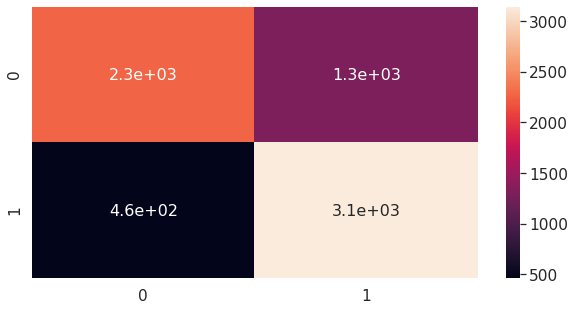

In [ ]:

c_m = confusion_matrix(Y_test.astype('int'), Y_pred_test_class.astype('int'))

df_cm = pd.DataFrame(c_m, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

##### Claim verification evaluation

In [ ]:
# Function to find the evidences associated to a claim
def check_equal_claim(df_test):
  claims = df_test['claim'].tolist()

  same_claim = {}
  for index, claim in enumerate(claims):
    if same_claim.get(claim) == None:
      same_claim[claim] = [index]
    else:
      same_claim[claim].append(index)

  return same_claim


# Function to handle the voting process
def voting(Y_test, same_claim):
  Y_for_voting = []
  for el in same_claim:
    list_evid = same_claim[el]
    list_labels=[Y_test[evidence] for evidence in list_evid]
    result_of_voting = sum(list_labels)/len(list_labels)
    Y_for_voting.append(np.round(result_of_voting))

  return Y_for_voting

In [ ]:
same_claim=check_equal_claim(df_test)

In [ ]:
# Print that is useful for debugging
len(df_test)
len(Y_pred_test_class)

7189

In [ ]:
#Apply voting process to both true labels (Y_test) and predicted labels (Y_pred_test_class)
Y_test_voting = voting (Y_test,same_claim)
Y_pred_voting = voting (Y_pred_test_class,same_claim)

# Print for debugging
print(len(Y_test))
print(len(Y_pred_test_class))

print(len(Y_test_voting))
print(len(Y_pred_voting))

7189
7189
6523
6523


In [ ]:
# Report here
report = classification_report(np.array(Y_test_voting).astype('int'), np.array(Y_pred_voting).astype('int'))
print(report)

              precision    recall  f1-score   support

           0       0.82      0.63      0.71      3251
           1       0.70      0.87      0.78      3272

    accuracy                           0.75      6523
   macro avg       0.76      0.75      0.74      6523
weighted avg       0.76      0.75      0.74      6523

